In [20]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

[autoreload of anndata.utils failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 621, in superreload
    update_generic(old_obj, new_obj)
    ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 447, in update_generic
    update(a, b)
    ~~~~~~^^^^^^
  File "/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 415, in update_class
    update_instances(old, new)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^
  File "/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 373, in update_instances
    object.__setattr__(ref, "_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import seaborn as sns
import scrublet as scr



In [22]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [23]:
mouse_colors = plt.cm.colors.ListedColormap(['red', 'darkred', 'blue','darkblue', 'orange', 'darkorange', 'violet', 'darkviolet',])

samples = [
    "GSM6321073_PFC_4wk_1_matrix.h5",
    "GSM6321077_PFC_90wk_1_matrix.h5",
]

mouse_id = {
    0 : 1,
    1 : 1
}

In [24]:
#adata= sc.read_h5ad("/Users/cmdb/qb25project/mouse-brain-RNAseq/dataset.h5ad")
#print(adata)

In [25]:
#print(adata[:10])

In [26]:
#adata.write("RNAseq-converted-10x.h5")

In [27]:
all_adata = []
i = 0
for s in samples:
    label, area, age, idx, _ = s.split("_")
    print(label, area, age, idx)
    curr_adata = sc.read_10x_h5(f"/Users/cmdb/qb25project/mouse-brain-RNAseq/GSE207848_RAW/{s}")
    curr_adata.var_names_make_unique()
    curr_adata.obs['area'] = area
    curr_adata.obs['age'] = age
    curr_adata.obs['idx'] = i
    i += 1
    curr_adata.var['mt'] = curr_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(curr_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    all_adata.append(curr_adata)


GSM6321073 PFC 4wk 1
reading /Users/cmdb/qb25project/mouse-brain-RNAseq/GSE207848_RAW/GSM6321073_PFC_4wk_1_matrix.h5


/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


ValueError: `X` has to be an AnnData object.

In [ ]:
total_cells = np.sum([a.n_obs for a in all_adata])
print('total cells:', total_cells)

total cells: 28818


In [ ]:
adata = ad.concat(all_adata)

/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
adata[adata.obs.area=='PFC']

View of AnnData object with n_obs × n_vars = 28818 × 32285
    obs: 'area', 'age', 'idx', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'

In [ ]:
adata.obs_names_make_unique()

In [ ]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_cells(adata, max_counts=100000)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=2500)

filtered out 1766 cells that have less than 1000 genes expressed
filtered out 24 cells that have more than 100000 counts
filtered out 6412 genes that are detected in less than 3 cells
filtered out 1369 cells that have less than 2500 counts


In [ ]:
adata

AnnData object with n_obs × n_vars = 25659 × 25873
    obs: 'area', 'age', 'idx', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
    var: 'n_cells'

In [ ]:
adata.obs['mouse_id'] = [mouse_id[i] for i in adata.obs.idx]

In [ ]:
# run scrublet on adata to identify doublets
scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.09)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 9.2%
Estimated detectable doublet fraction = 66.2%
Overall doublet rate:
	Expected   = 9.0%
	Estimated  = 13.9%
Elapsed time: 27.5 seconds


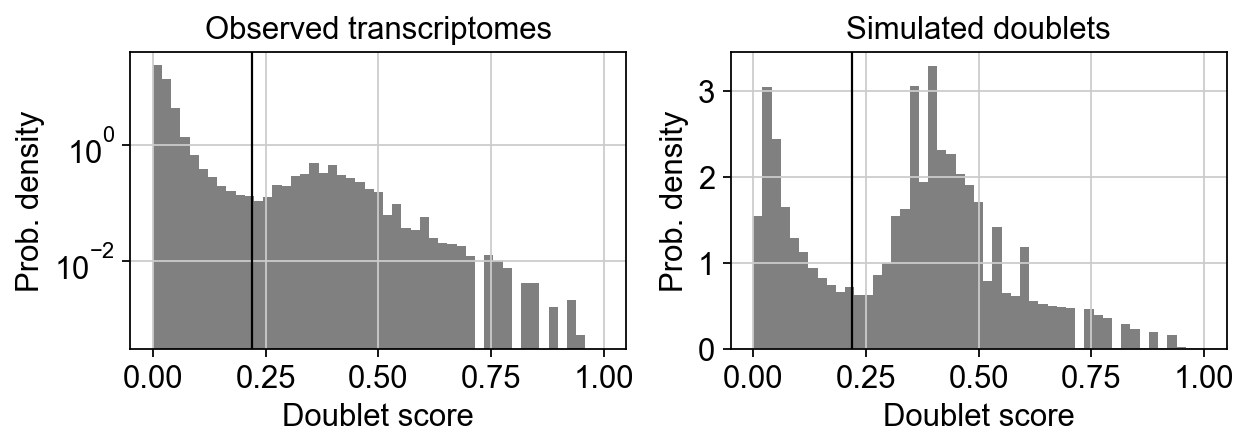

In [ ]:
scrub.plot_histogram();

In [ ]:
np.sum(predicted_doublets)/len(doublet_scores)

np.float64(0.09174168907595776)

In [ ]:
adata = adata[~predicted_doublets,:]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 23305 × 25873
    obs: 'area', 'age', 'idx', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'mouse_id'
    var: 'n_cells'

/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


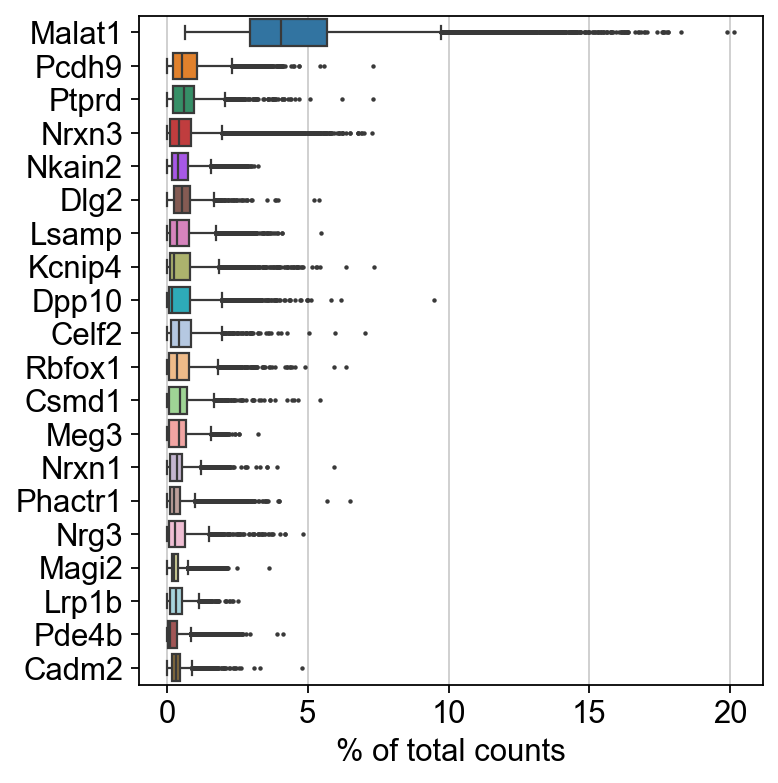

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [ ]:
adata.write("adata_combined_nodoublet.h5ad")

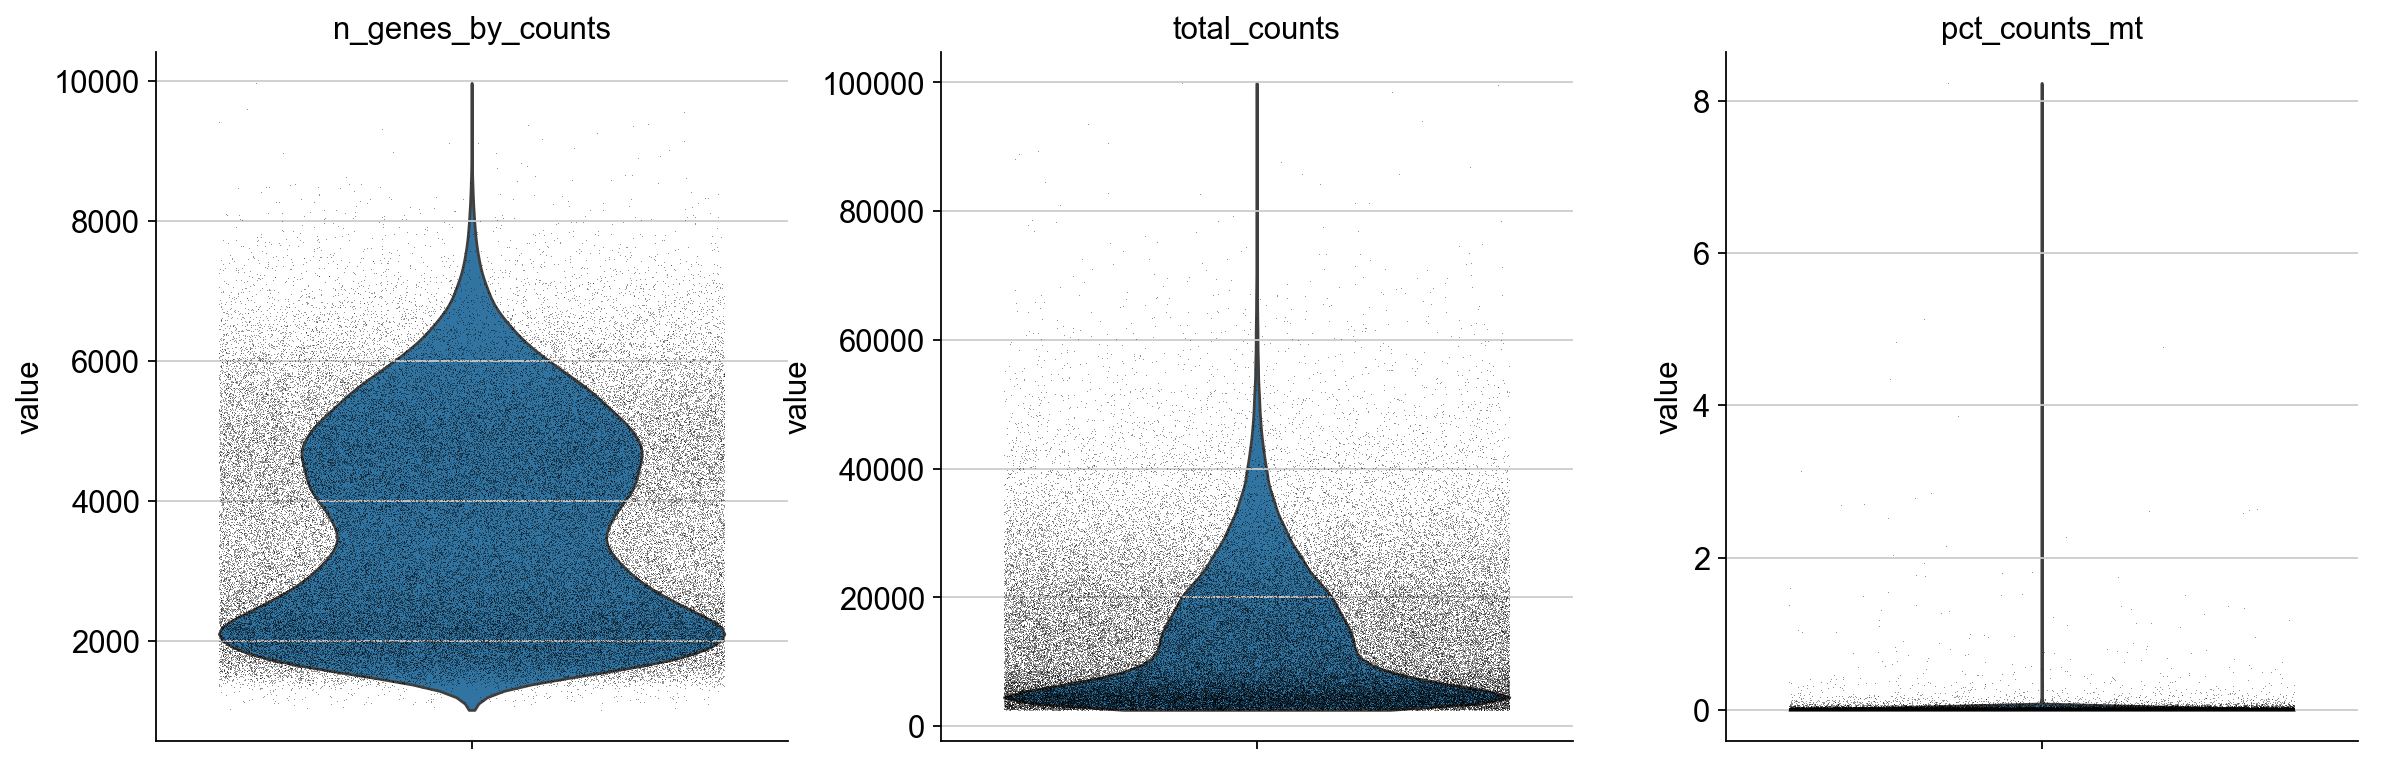

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,size=0.25)

In [ ]:
print(np.median(adata.obs.n_genes_by_counts))

3332.0


In [ ]:
print(np.median(adata.obs.total_counts))

9699.0


In [ ]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :]

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


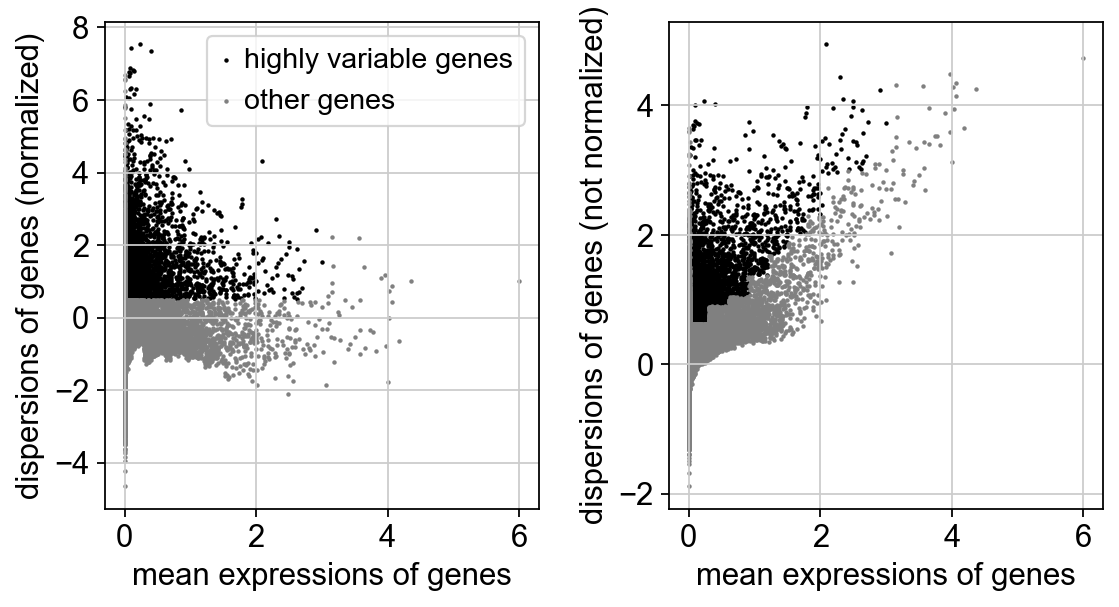

In [ ]:
sc.pl.highly_variable_genes(adata)

regressing out ['total_counts', 'pct_counts_mt']


/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    sparse input is densified and may lead to high memory use
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:03)


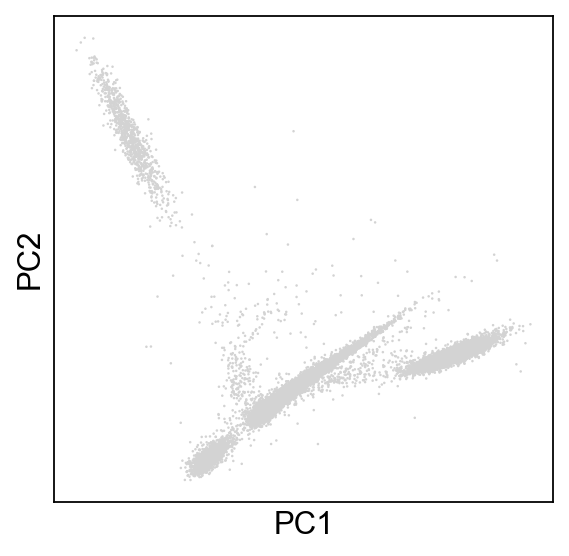

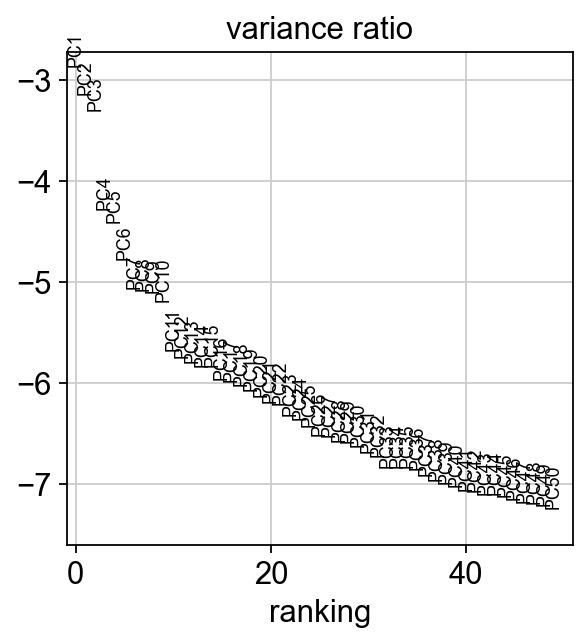

computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/anaconda3/envs/qbproject/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [ ]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)
running Leiden clustering


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_90864/1101034265.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=0.2)


    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


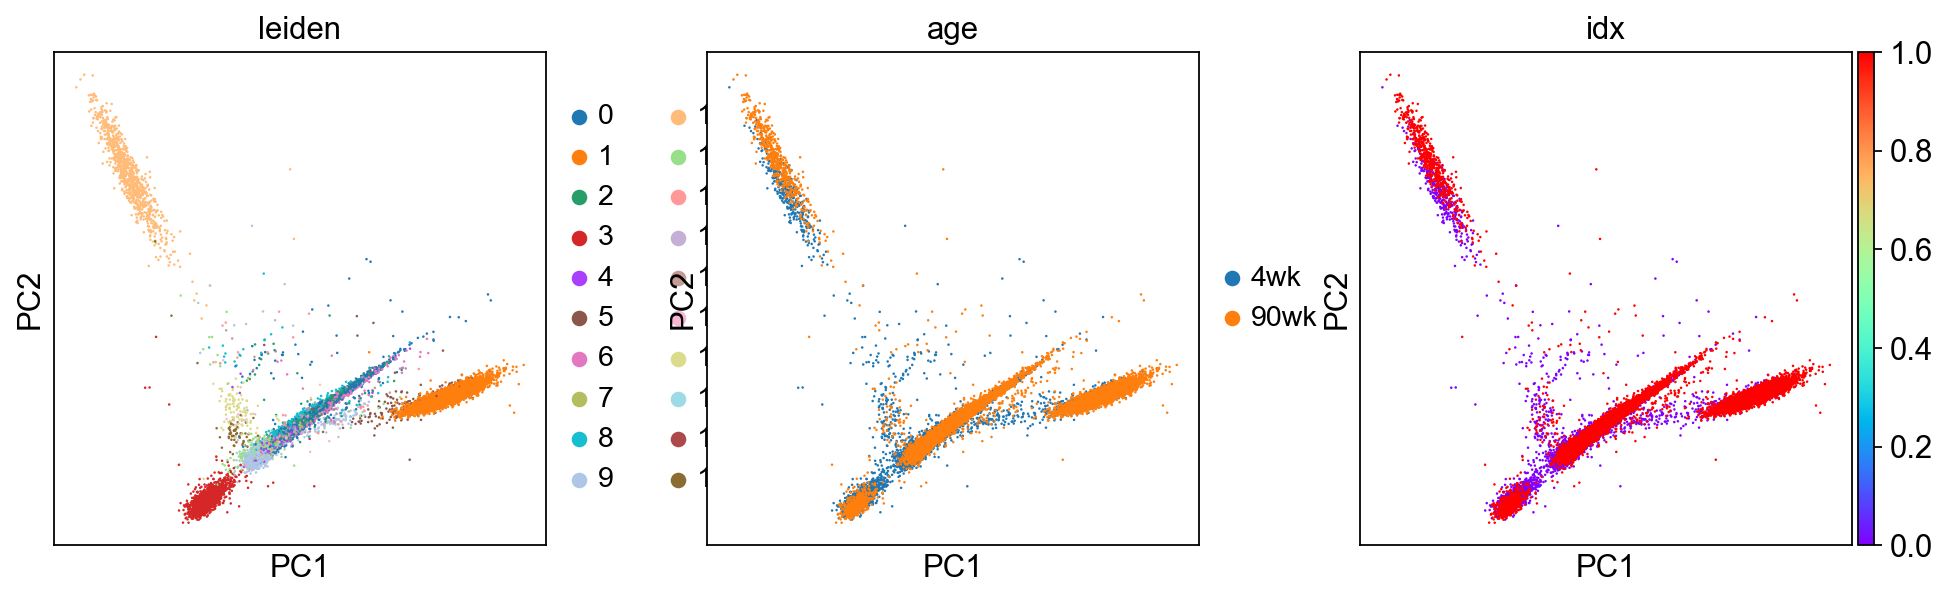

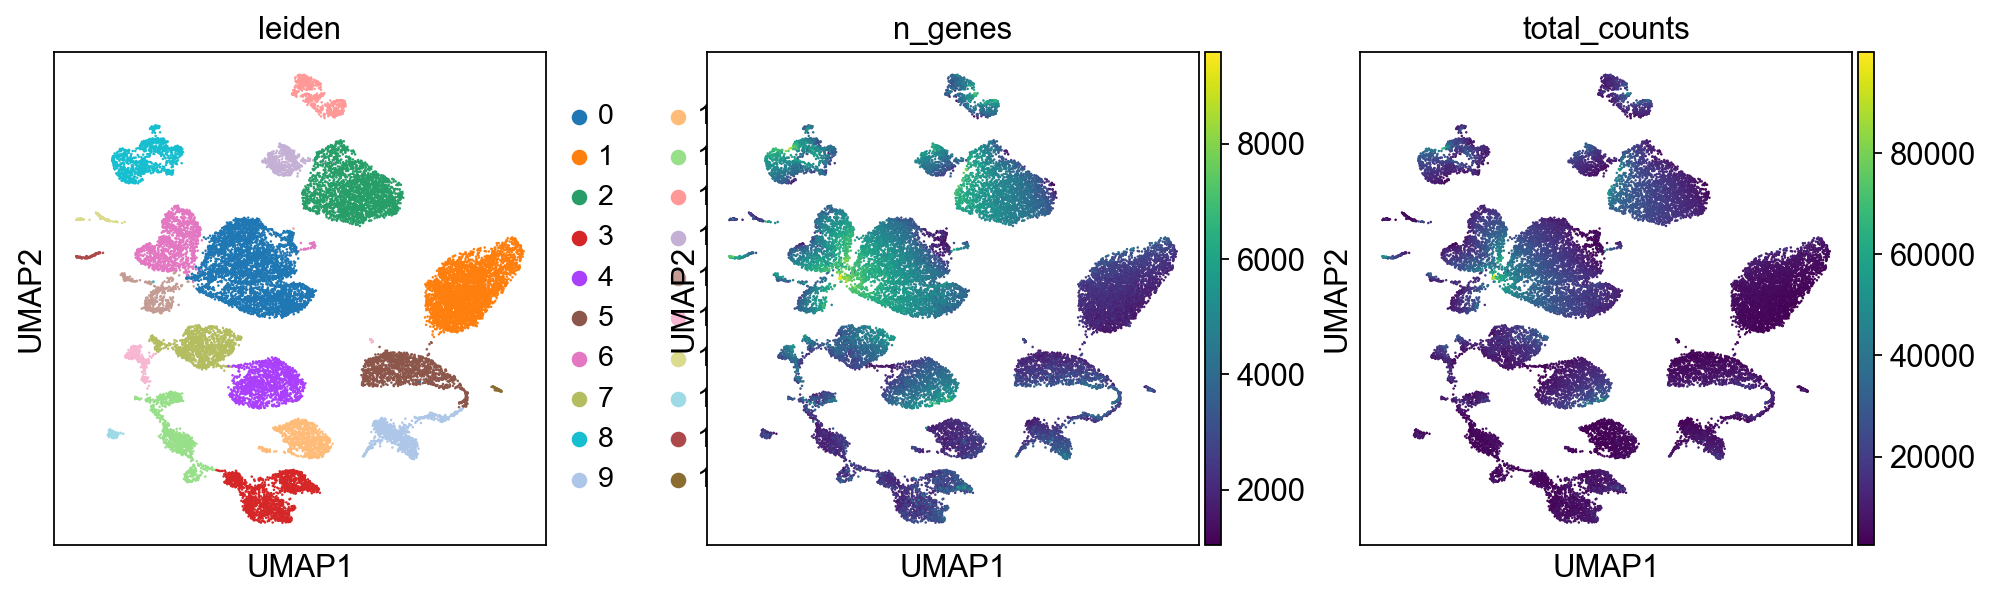

In [ ]:
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.2)
sc.pl.pca(adata,color=['leiden','age','idx'],color_map=plt.cm.rainbow)
sc.pl.umap(adata, color=['leiden','n_genes','total_counts'],color_map=plt.cm.viridis)
adata.write("adata_combined_nodoublet_normalized.h5ad")

In [ ]:
import anndata as ad
adata = ad.read_h5ad('adata_combined_nodoublet.h5ad')

#print(adata.obs.tail(n= 50))  # This shows the last few rows of cell metadata (annotations)

adata.obs.dtypes

# for i in adata.X:
#     print(i)

# print(adata.obs["age"])
# for i in adata.obs["age"]:
#     print(i)

#print(adata.obs["n_genes"])
#print(adata.obs["n_genes_by_counts"])

with open ('age.tsv', "w") as f:
    for i in range(len(adata.obs['age'])):
        #print(adata.obs_names[i], adata.obs["age"][i])
        f.write(adata.obs_names[i] + "\t" + adata.obs["age"][i] + "\n")




/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_13903/2399981461.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f.write(adata.obs_names[i] + "\t" + adata.obs["age"][i] + "\n")
